<a href="https://colab.research.google.com/github/MatCat960/pf-training/blob/main/12_coverage_vel_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a Neural Network to perform distributed Coverage

In [55]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import math

from pathlib import Path
from copy import deepcopy as dc

In [56]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {device}")

Using device: cuda


In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
path = Path("/content/drive/MyDrive/Colab Notebooks/PyTorch tutorial/coverage_centralized_vel").glob('**/*')
files = [x for x in path if x.is_file()]

In [59]:
len(files)

25

In [60]:
ROBOTS_NUM = 6
lookback = 7
AREA_W = 30.0
AREA_H = 30.0
GRID_STEPS = 64
ROBOT_RANGE = 15.0
ROBOT_FOV = 120.0

## Utility Functions

In [61]:
def in_fov(robot, target, fov, range):
  fov_rad = fov * math.pi / 180.0
  xr = robot[0]
  yr = robot[1]
  phi = robot[2]
  dx = target[0] - xr
  dy = target[1] - yr
  dist = math.sqrt(dx**2 + dy**2)
  if dist > range:
    return 0

  xrel = dx * math.cos(phi) + dy * math.sin(phi)
  yrel = -dy * math.sin(phi) + dy * math.cos(phi)
  angle = abs(math.atan2(yrel, xrel))
  if (angle <= fov_rad) and (xrel >= 0.0):
    return 1
  else:
    return 0

In [62]:
def gauss_pdf(x, y, means, covs):
  """
  Calculate the probability in the cell (x,y)

  Args:
    x (float) : x coord of the considered point
    y (float) : y coord of the considered point
    means (list(np.array)) : list of mean points
    covs (list(np.array)) : list of covariance matrices
  """

  prob = 0.0
  for i in range(len(means)):
    m = means[i]
    cov = covs[i]
    exp = -0.5 * np.sum

In [63]:
# X, Y : meshgrid
def multigauss_pdf(X, Y, means, sigmas):
  # Flatten the meshgrid coordinates
  points = np.column_stack([X.flatten(), Y.flatten()])

  # Number of components in the mixture model
  num_components = len(means)


  # Initialize the probabilities
  probabilities = np.zeros_like(X)

  # Calculate the probability for each component
  for i in range(num_components):
      mean = means[i]
      covariance = sigmas[i]

      # Calculate the multivariate Gaussian probability
      exponent = -0.5 * np.sum((points - mean) @ np.linalg.inv(covariance) * (points - mean), axis=1)
      coefficient = 1 / np.sqrt((2 * np.pi) ** 2 * np.linalg.det(covariance))
      component_prob = coefficient * np.exp(exponent)

      # Add the component probability weighted by its weight
      probabilities += component_prob.reshape(X.shape)

  return probabilities

In [64]:
def plot_fov(fov_deg, radius, ax):
  # fig = plt.figure(figsize=(6,6))
  # plt.scatter(neighs[:, 0], neighs[:, 1], marker='*')

  x1 = np.array([0.0, 0.0, 0.0])
  fov = fov_deg * math.pi / 180
  arc_theta = np.arange(-0.5*fov, 0.5*fov, 0.01*math.pi)
  th = np.arange(fov/2, 2*math.pi+fov/2, 0.01*math.pi)

  # FOV
  xfov = radius * np.cos(arc_theta)
  xfov = np.append(x1[0], xfov)
  xfov = np.append(xfov, x1[0])
  yfov = radius * np.sin(arc_theta)
  yfov = np.append(x1[1], yfov)
  yfov = np.append(yfov, x1[1])
  ax.plot(xfov, yfov)

In [65]:
def generate_sequence_tensor(original_tensor, sequence_length=5):
    num_samples, cols = original_tensor.shape
    sequence_tensor = torch.zeros(num_samples, sequence_length, cols)

    # sequence_tensor[:, 0, :, :, :] = original_tensor.roll(0, dims=0)
    for i in range(0, sequence_length):
        sequence_tensor[:, i, :] = original_tensor.roll(-i, dims=0)

    return sequence_tensor

In [66]:
from numpy import linalg as LA

def plot_ellipse(ctr, cov, ax, s=4.605):
  """
  Args:
    ctr (np.array(1, 2)): center of the ellipse
    cov (np.array(2, 2)): covariance matrix
    s (double): confidence interval
  """

  epsilon = 0.01

  eigenvalues, eigenvectors = LA.eigh(cov)
  eigenvalues = eigenvalues + epsilon
  # print(f"Eigenvalues: {eigenvalues}")
  # if eigenvalues[0] < 0.0 or eigenvalues[1] < 0.0:
  #   print(f"Cov matrix: {cov}")
  #   print(f"Eigenvalues: {eigenvalues}")
  # eigenvalues[eigenvalues < 0.0] = 0.1
  a = math.sqrt(s*abs(eigenvalues[0]))
  b = math.sqrt(s*abs(eigenvalues[1]))

  if (a < b):
    temp = dc(a)
    a = dc(b)
    b = temp

  print(f"Major axis: {a}")

  m = 0
  l = 1
  if eigenvalues[1] > eigenvalues[0]:
    m = 1
    l = 0

  theta = math.atan2(eigenvectors[1,m], eigenvectors[0,m])
  if theta < 0.0:
    theta += math.pi

  vx = []; vy = []
  x = ctr[0]
  y = ctr[1]
  for phi in np.arange(0, 2*np.pi, 0.1):
    xs = x + a * np.cos(phi) * np.cos(theta) - b * np.sin(phi) * np.sin(theta)
    ys = y + a * np.cos(phi) * np.sin(theta) + b * np.sin(phi) * np.cos(theta)
    vx.append(xs)
    vy.append(ys)

  vx.append(vx[0])
  vy.append(vy[0])

  # fig = plt.figure(figsize=(6,6))
  ax.plot(vx, vy)






In [67]:
data = []
sizes = []
for file in files:
  with open(file) as f:
    lines = f.readlines()
    sizes.append(len(lines))

  for l in lines:
    data.append(l)

print(data[0])

poses = np.zeros([len(data), 2], dtype="float32")

for i in range(len(data)):
  data[i] = data[i].replace('\n', '')
  poses[i] = tuple(map(float, data[i].split(' ')))

5.999980 10.000062



## Split poses and velocities

In [68]:
pos = np.zeros((int(len(data)/2), 2), dtype="float32")
vel = np.zeros_like(pos)

print(poses[0])
print(f"Original length: {len(poses)}")
print(f"Pos length: {len(pos)}")

for i in range(0, len(pos)):
  pos[i] = poses[2*i]
  vel[i] = poses[2*i+1]



[ 5.99998  10.000062]
Original length: 99952
Pos length: 49976


In [69]:
pos[0]

array([ 5.99998 , 10.000062], dtype=float32)

## Convert numpy to torch.Tensor

In [80]:
X = torch.from_numpy(pos).to(device)
y = torch.from_numpy(vel).to(device)

In [81]:
X[:ROBOTS_NUM, :]
X.shape, y.shape

(torch.Size([49976, 2]), torch.Size([49976, 2]))

In [84]:
# X, y = X[:-4], y[:-4]
s = int(X.shape[0]/ROBOTS_NUM)

X = X[:s*ROBOTS_NUM]
y = y[:s*ROBOTS_NUM]

In [85]:
X = X.view(-1, 2*ROBOTS_NUM)
y = y.view(-1, 2*ROBOTS_NUM)

In [86]:
X.shape, y.shape

(torch.Size([8329, 12]), torch.Size([8329, 12]))

## Scale values

In [87]:
from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler(feature_range=(-1,1))
# X_scaled = scaler.fit_transform(X.cpu())
# # y_scaled = scaler.fit_transform(y.cpu())
# X_new = np.float32(X_scaled)
# # y_new = y_scaled

# X = torch.from_numpy(X_new)
# print(type(X))
# y = torch.from_numpy(y_new)

## Create train and test split

In [88]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2)

y_train = y_train.squeeze(1)
y_test = y_test.squeeze(1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6663, 12]),
 torch.Size([1666, 12]),
 torch.Size([6663, 12]),
 torch.Size([1666, 12]))

In [89]:
from torch.utils.data import TensorDataset, DataLoader

# create TensorDatasets for training and testing sets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [90]:
for input, target in train_loader:
  print(input.shape, target.shape)
  break

torch.Size([64, 12]) torch.Size([64, 12])


## Define neural network model

In [162]:
class CoverageModel(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.input_size = input_size
    self.output_size = output_size

    self.fc1 = nn.Linear(input_size, 64)
    self.fc2 = nn.Linear(64, 32)
    self.fc3 = nn.Linear(32, output_size)
    self.relu = nn.ReLU()
    self.activation = nn.Sigmoid()

  def forward(self, x):
    x = self.activation(self.fc1(x))
    x = self.activation(self.fc2(x))
    x = self.fc3(x)

    return x

In [163]:
class CoverageModel2(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.input_size = input_size
    self.output_size = output_size

    self.fc1 = nn.Linear(input_size, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 32)
    self.fc4 = nn.Linear(32, output_size)
    self.relu = nn.ReLU()
    # self.activation = nn.Sigmoid()
    self.activation = nn.Tanh()

    self.scale_param = nn.Parameter(torch.ones(1))

  def forward(self, x):
    x = self.activation(self.fc1(x))
    x = self.activation(self.fc2(x))
    x = self.activation(self.fc3(x))
    x = self.fc4(x)

    # x[:, 4] = x[:, 3]

    # cov_matrix = x[:, 2:]
    # cov_matrix = cov_matrix.view(-1, 2, 2)
    # scaled_cov_matrix = cov_matrix * self.scale_param
    # scaled_cov_matrix = scaled_cov_matrix.view(-1, 4)

    # out = torch.cat((x[:, :2], scaled_cov_matrix), dim=1)

    return x

## Training

In [134]:
model = CoverageModel2(2 * ROBOTS_NUM, 2 * ROBOTS_NUM)
model = model.to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

RUN_BATCHED = False

## Train on unbatched data

In [135]:
if not RUN_BATCHED:
  epochs = 5000
  epsilon = 0.01

  for epoch in range(epochs):
    model.train()
    y_pred = model(X_train)
    if epoch == 0:
      print(f"output shape: {y_pred.shape}")
      print(f"Target shape: {y_train.shape}")
    loss = loss_fn(y_pred, y_train)
    torch.autograd.set_detect_anomaly(True)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
      test_pred = model(X_test)
      test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss.item()} | Test loss: {test_loss.item()}")

output shape: torch.Size([6663, 12])
Target shape: torch.Size([6663, 12])
Epoch: 0 | Loss: 0.2516896426677704 | Test loss: 0.2273460179567337
Epoch: 100 | Loss: 0.036019161343574524 | Test loss: 0.0342940092086792
Epoch: 200 | Loss: 0.01962163671851158 | Test loss: 0.018851421773433685
Epoch: 300 | Loss: 0.011504605412483215 | Test loss: 0.011751176789402962
Epoch: 400 | Loss: 0.006881923880428076 | Test loss: 0.0075459666550159454
Epoch: 500 | Loss: 0.004477848764508963 | Test loss: 0.005376735236495733
Epoch: 600 | Loss: 0.0032757087610661983 | Test loss: 0.004377112258225679
Epoch: 700 | Loss: 0.002589603653177619 | Test loss: 0.0038273304235190153
Epoch: 800 | Loss: 0.002137955743819475 | Test loss: 0.003439192660152912
Epoch: 900 | Loss: 0.0017859248910099268 | Test loss: 0.003134737256914377
Epoch: 1000 | Loss: 0.0015435797395184636 | Test loss: 0.002918030135333538
Epoch: 1100 | Loss: 0.0013594763586297631 | Test loss: 0.0027644862420856953
Epoch: 1200 | Loss: 0.0012106340145692

In [ ]:
# for name, param in model.named_parameters():
#   if param.requires_grad:
#     print(name, param)

## Test on simulated robots

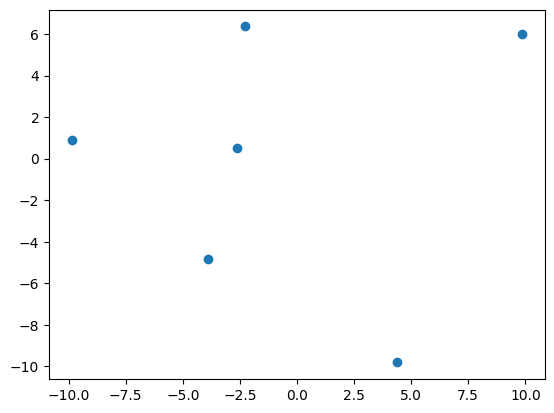

In [145]:
import random

robots = np.zeros((ROBOTS_NUM, 2), dtype="float32")
for i in range(ROBOTS_NUM):
  robots[i, :] = -10.0 + 20.0 * np.random.rand(1, 2)

# robots = np.array(([-4.0, 4.0],
#                   [-4.0, -4.0],
#                   [4.0, -4.0],
#                   [4.0, 4.0],
#                   [6.0, 0.0],
#                   [-6.0, 0.0]),
#                   dtype="float32")

# robots = robots - 8.0
plt.scatter(robots[:, 0], robots[:, 1])
Xt = torch.from_numpy(robots)
Xt = Xt.view(-1, ROBOTS_NUM*2)
Xt = Xt.to(device)

In [ ]:
Xt[0, 0]

## Forecast next steps

In [153]:
NUM_STEPS = 500
dt = 0.2

X_hist = [Xt]
# v_hist = []

r_hist = []

In [157]:
for i in range(ROBOTS_NUM):
  r = []
  r_hist.append(r)

robots_hist = torch.Tensor(NUM_STEPS, ROBOTS_NUM, 2)
print(robots_hist.shape)

for i in range(NUM_STEPS):
  # get velocity
  v_pred = model(Xt)
  # print(f"Vpred : {v_pred}")

  # move robots
  # v = v_pred.view(ROBOTS_NUM, 2)

  # for j in range(2*ROBOTS_NUM):
  Xt[0, :] = Xt[0, :] + v_pred[0, :] * dt
  # print(f"Actual Xt: {Xt}")

  xp = Xt.view(ROBOTS_NUM, 2)
  for j in range(ROBOTS_NUM):
    robots_hist[i, j, :] = xp[j, :]

  X_hist.append(Xt)





torch.Size([500, 6, 2])


In [ ]:
robots_hist[:, 0, :]

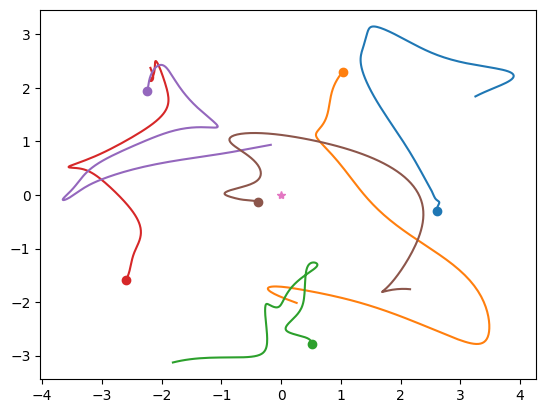

In [158]:
for i in range(ROBOTS_NUM):
  plt.plot(robots_hist[:, i, 0].cpu().detach().numpy(), robots_hist[:, i, 1].cpu().detach().numpy())

  # for i in range(ROBOTS_NUM):
  plt.scatter(robots_hist[-1, i, 0].cpu().detach().numpy(), robots_hist[-1, i, 1].cpu().detach().numpy())

plt.plot(0.0, 0.0, '*')

## Plot final position

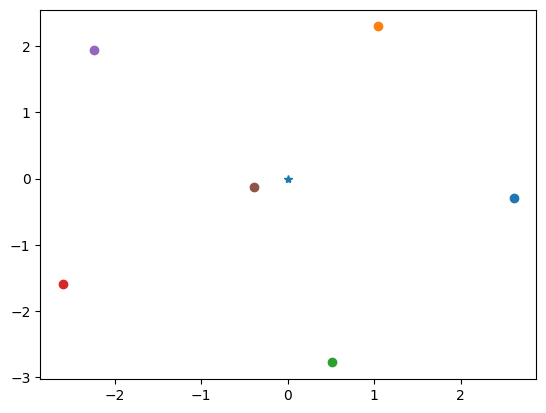

In [161]:
for i in range(ROBOTS_NUM):
  plt.scatter(robots_hist[-1, i, 0].cpu().detach().numpy(), robots_hist[-1, i, 1].cpu().detach().numpy())

plt.plot(0.0, 0.0, '*')